In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
revenue_data = pd.read_csv('files/applerevenue.csv')
revenue_data

,date,open,high,low,close,volume,profit or not
0,12-12-1980,0.1003,0.1007,0.1003,0.1003,469033600,0
1,15-12-1980,0.0955,0.0955,0.0951,0.0951,175884800,1
2,16-12-1980,0.0885,0.0885,0.0881,0.0881,105728000,1
3,17-12-1980,0.0902,0.0907,0.0902,0.0902,86441600,0
4,18-12-1980,0.0929,0.0933,0.0929,0.0929,73449600,0
...,...,...,...,...,...,...,...
10554,24-10-2022,147.1850,150.2300,146.0000,149.4500,75569074,0
10555,25-10-2022,150.0900,152.4900,149.3600,152.3400,73583421,0
10556,26-10-2022,150.9600,151.9900,148.0400,149.3500,87769611,1
10557,27-10-2022,148.0700,149.0460,144.1300,144.8000,108110875,1


In [3]:
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10559 entries, 0 to 10558
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           10559 non-null  object 
 1   open           10559 non-null  float64
 2   high           10559 non-null  float64
 3   low            10559 non-null  float64
 4   close          10559 non-null  float64
 5   volume         10559 non-null  int64  
 6   profit or not  10559 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 577.6+ KB


In [4]:
revenue_data.describe()

,open,high,low,close,volume,profit or not
count,10559.000000,10559.000000,10559.000000,10559.000000,1.055900e+04,10559.000000
mean,15.308827,15.483090,15.139373,15.318012,3.263275e+08,0.476466
std,33.973113,34.385796,33.580974,34.000790,3.201156e+08,0.499469
min,0.038800,0.038800,0.038400,0.038400,1.001504e+06,0.000000
25%,0.236800,0.242500,0.231650,0.236900,1.219792e+08,0.000000
50%,0.400200,0.406600,0.393000,0.399300,2.159780e+08,0.000000
75%,13.652700,13.783300,13.504000,13.647150,4.074518e+08,1.000000
max,181.877900,182.186600,178.382400,181.260500,2.147484e+09,1.000000


In [5]:
revenue_data.isnull().sum()

date             0
open             0
high             0
low              0
close            0
volume           0
profit or not    0
dtype: int64

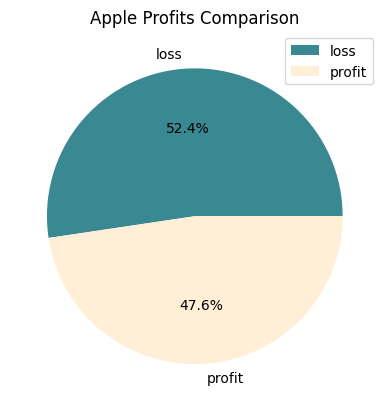

In [6]:
classes = revenue_data['profit or not'].value_counts().to_dict()

colors = ["#3A8891", '#FFEFD6']
labels = list(classes.keys())
values = list(classes.values())

plt.pie(values, labels=['loss', 'profit'], colors=colors, autopct="%.1f%%")
plt.title('Apple Profits Comparison')
plt.legend()
plt.show()

In [7]:
revenue_data['date'] = pd.to_datetime(revenue_data['date'], format="%d-%m-%Y")
revenue_data.set_index('date', inplace=True)
revenue_data

,open,high,low,close,volume,profit or not
date,,,,,,
1980-12-12,0.1003,0.1007,0.1003,0.1003,469033600,0
1980-12-15,0.0955,0.0955,0.0951,0.0951,175884800,1
1980-12-16,0.0885,0.0885,0.0881,0.0881,105728000,1
1980-12-17,0.0902,0.0907,0.0902,0.0902,86441600,0
1980-12-18,0.0929,0.0933,0.0929,0.0929,73449600,0
...,...,...,...,...,...,...
2022-10-24,147.1850,150.2300,146.0000,149.4500,75569074,0
2022-10-25,150.0900,152.4900,149.3600,152.3400,73583421,0
2022-10-26,150.9600,151.9900,148.0400,149.3500,87769611,1


<Axes: xlabel='date', ylabel='open'>

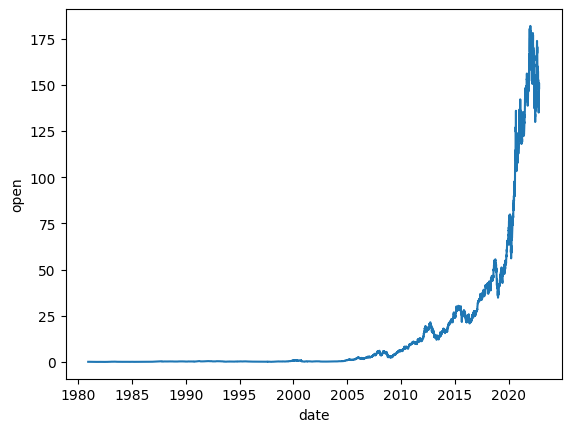

In [8]:
sns.lineplot(data=revenue_data,x=revenue_data.index,y=revenue_data.open)

In [9]:
data = revenue_data['open'].values.reshape(-1, 1)  # Convert to (n, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Properly scaled data

In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Sequence of length `seq_length`
        y.append(data[i + seq_length])    # Corresponding target value
    return np.array(X), np.array(y)


In [11]:
revenue_data

,open,high,low,close,volume,profit or not
date,,,,,,
1980-12-12,0.1003,0.1007,0.1003,0.1003,469033600,0
1980-12-15,0.0955,0.0955,0.0951,0.0951,175884800,1
1980-12-16,0.0885,0.0885,0.0881,0.0881,105728000,1
1980-12-17,0.0902,0.0907,0.0902,0.0902,86441600,0
1980-12-18,0.0929,0.0933,0.0929,0.0929,73449600,0
...,...,...,...,...,...,...
2022-10-24,147.1850,150.2300,146.0000,149.4500,75569074,0
2022-10-25,150.0900,152.4900,149.3600,152.3400,73583421,0
2022-10-26,150.9600,151.9900,148.0400,149.3500,87769611,1


## RNN (LSTM) Model Building

In [12]:
# Define sequence length
sequence_length = 10  
X, y = create_sequences(scaled_data, sequence_length)

print("Shape of X:", np.shape(X))  # Should be (num_samples, sequence_length)
print("Shape of y:", np.shape(y))  # Should be (num_samples,)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse}")

Shape of X: (10549, 10, 1)
Shape of y: (10549, 1)
Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1502e-04
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7109e-06
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1161e-06
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7172e-06
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8802e-06
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5165e-06
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6278e-06
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6164e-06
Epoch 9/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5676e-06
Epoch 10/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9992e-06
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3091e-04
Mean Squared Error: 0.0007763718022033572


## Model Evaluation

In [13]:
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform the scaled predicted and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


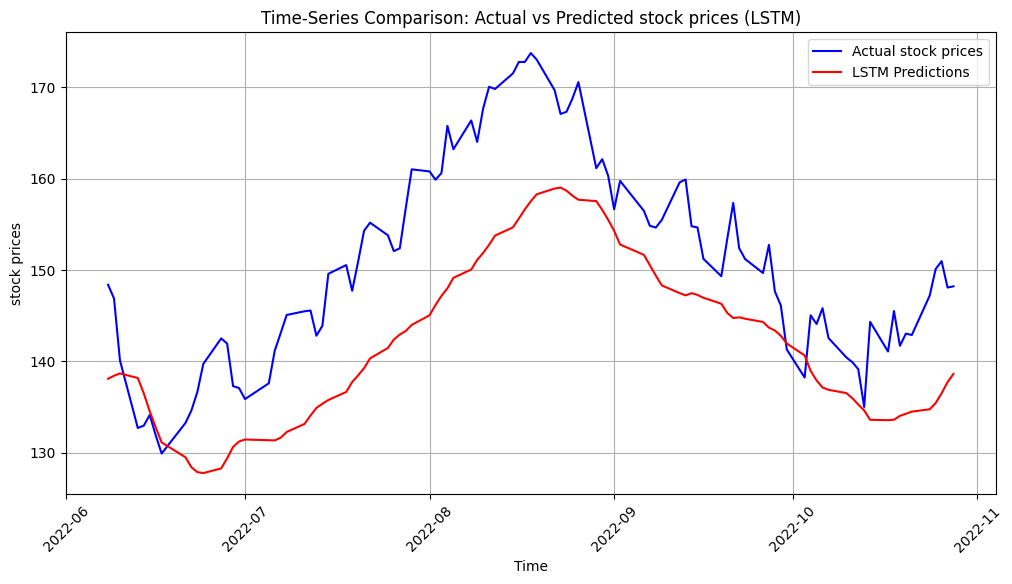

In [14]:
# Prepare the data for plotting
# Ensure `data` is a Pandas DataFrame or Series before using `.index`
df_pred_actual = pd.DataFrame({
    "Actual stock prices": y_actual.flatten(),
    "Predicted stock prices": y_pred.flatten(),
}, index=revenue_data.index[-len(y_actual):])  # Use the last matching index

# Use the last 100 points for visualization
df_first_100 = df_pred_actual.tail(100)

# Plot with Seaborn
plt.figure(figsize=(12, 6))

# Plot the Actual stock prices
sns.lineplot(data=df_first_100, x=df_first_100.index, y="Actual stock prices", label="Actual stock prices", color='blue')

# Plot the LSTM predictions
sns.lineplot(data=df_first_100, x=df_first_100.index, y="Predicted stock prices", label="LSTM Predictions", color='red')
plt.xticks(rotation=45)  # Rotate labels for readability

# Add labels, legend, and title
plt.xlabel("Time")
plt.ylabel("stock prices")
plt.title("Time-Series Comparison: Actual vs Predicted stock prices (LSTM)")
plt.legend()

# Display the grid and plot
plt.grid(True)
plt.show()


In [15]:
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_actual, y_pred)
r_score = r2_score(y_actual, y_pred)

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.3f}')
print(f'R2 score: {r_score:.3f}')

MAE: 2.910
MSE: 25.671
RMSE: 5.067
MAPE: 0.031
R2 score: 0.989


In [16]:
import pickle

model.save("files/revenue_prediction_model.keras")
pickle.dump(scaler,open("files/revenue_prediction_Scaler.pkl",'wb'))

## 1-Month Forecasting

In [17]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def forecast_revenue(fixed_date, varying_date, sequence_length, future_steps):
    # Load the trained model and scaler
    model = pickle.load(open("files/revenue_prediction_model.pkl", 'rb'))
    scaler = pickle.load(open("files/revenue_prediction_Scaler.pkl", 'rb'))

    # Ensure dates are in datetime format
    fixed_date = pd.to_datetime(fixed_date)
    varying_date = pd.to_datetime(varying_date)

    # Extract the last known sequence for prediction
    revenue_data.index = pd.to_datetime(revenue_data.index)
    future_data = scaled_data[-sequence_length:]  # Ensure correct sequence length

    future_predictions = []
    for _ in range(future_steps):  
        input_data = future_data[-sequence_length:].reshape(1, sequence_length, 1)
        prediction = model.predict(input_data)
        future_predictions.append(prediction[0][0])
        
        # Append new prediction while keeping sequence length constant
        future_data = np.append(future_data[-(sequence_length - 1):], prediction)

    # Inverse transform to get actual values
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Generate future dates
    last_date = revenue_data.index.max()
    future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, future_steps + 1)]

    # Create a DataFrame for results
    forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Revenue": future_predictions.flatten()})

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=revenue_data, x=revenue_data.index, y="open", label="Actual Revenue", color="blue")
    sns.lineplot(data=forecast_df, x="Date", y="Predicted Revenue", label="Predicted Revenue", color="red", linestyle="dashed")

    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.title("Revenue Forecasting")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    graph_path = "files/revenue_prediction_result.png"
    plt.savefig(graph_path, bbox_inches="tight")
    plt.close()
    plt.show()

    return forecast_df,graph_path

# Example usage
forecast_df = forecast_revenue("2022-10-28", "2022-11-01", sequence_length=10, future_steps=30)
print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━